# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [21]:
// df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv', nrows=100000, sep='\t')

In [2]:
df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv',  sep='\t')

In [3]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [10]:
df_test = pd.read_csv('e:/DS/ds_hw/mercari/test.tsv', sep='\t')

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [12]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


Посмотрим на данные, общие статистики

In [6]:
df['price'].max(), df['price'].min(), df['price'].mean(),   df['price'].median()

(2009.0, 0.0, 26.737516146330442, 17.0)

Посмотрим распределение товаров по категориям

In [114]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [117]:
x = df['main_category'].value_counts().index.values.astype('str')
y = df['main_category'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(df))]

In [120]:
df['main_category'].nunique(), df['subcat_1'].nunique(), df['subcat_2'].nunique(), df['category_name'].nunique()

(10, 113, 827, 1200)

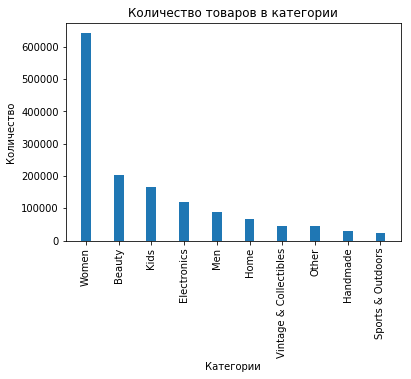

In [121]:
plt.bar(x,y,width=.3)
plt.xticks(x,x, rotation='vertical')
plt.xlabel('Категории')
plt.ylabel('Количество ')
plt.title('Количество товаров в категории')
plt.show()

Категориии детализированы очень подробно, поэтому каждый товар в опрделенной категории, очень схожи, те если 
это джинсовые леггинсы, то каждый представитель этой категории очень похож на любой другой. Поэтому учитывая бранд 
и состояние можно уже сделать предсказание цены, с каким-то усреднением.



### 1.Обработаем пустые значения и делаем encoding категориальных переменных
брэнд - заменим на missing, а пустые категории удалим

In [5]:
df.brand_name.fillna(value="Missing", inplace=True)


In [6]:
df[df['brand_name'].isnull()].count()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [7]:
df = df[df['category_name'].notnull()]

In [9]:
le = LabelEncoder()
le.fit(df.brand_name)
df['brand_name_i'] = le.transform(df.brand_name)

le.fit(df.category_name)
df['category_name_i'] = le.transform(df.category_name)

In [10]:
le.fit(df.name)
df['name_i'] = le.transform(df.name)

In [12]:
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_name_i,category_name_i,name_i
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Missing,10.00,1,No description yet,2876,808,637962
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3545,86,900109
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,4166,1254,91126
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Missing,35.00,1,New with tags. Leather horses. Retail for [rm]...,2876,485,558553
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Missing,44.00,0,Complete with certificate of authenticity,2876,1181,45278


### 2. Маштабируем и логарифмируем цену

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009D06BE0>]],
      dtype=object)

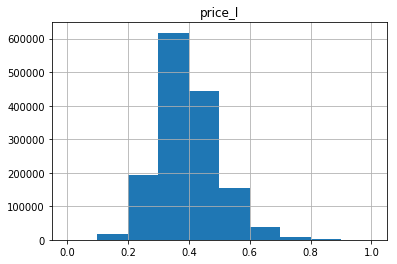

In [13]:
# Логарифмируем и маштабируем цену
df["price_l"] = np.log(df.price+1)
target_scaler = MinMaxScaler(copy=True,feature_range=(0, 1))
df["price_l"] = target_scaler.fit_transform(df[['price_l']])
pd.DataFrame(df.price_l).hist()

In [14]:
df['item_condition_id'].astype('object')
t = df[df['subcat_2'] =='T-shirts'].groupby('brand_name')['price'].mean().to_frame().sort_values(['brand_name'], ascending = True)
/*средняя цена категории*/
pr = df[df['subcat_2'] =='T-shirts']['price']

SyntaxError: invalid syntax (<ipython-input-14-ed1831d453a7>, line 3)

### 3. Удалим выбросы из выборки 
    Воспользуемся z-оценкой

In [15]:
df_mean = df.groupby(['category_name_i'])['price'].mean().to_frame()
df_mean = df_mean.rename(index=str, columns={"price": "mean"})
df_std = df.groupby(['category_name_i'])['price'].std().to_frame()
df_std = df_std.rename(index=str, columns={"price": "std"})
df_st = df_mean.join(df_std)

In [16]:
pr = df[df['category_name'] =='Men/Tops/T-shirts']['price']
pr.mean(), pr.std()

(18.35249536669314, 16.307762207703092)

In [17]:
df_st['category_name_i'] = df_st.index
df_st['category_name_i'] = df_st['category_name_i'].astype(int)
df = pd.merge(df,df_st, how = 'inner',left_on="category_name_i" , right_on="category_name_i" )

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'category_name_i' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
df['category_name_i'].nunique(),

(1287,)

In [19]:
#удаляем категории, в которых всего один объект
df_st = df_st[df_st['std'].notnull()]

In [20]:
df['z_score'] = ((df['price'] - df['mean'])/df['std']).abs()

In [21]:
df =  df[df['z_score'] <= 2]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425587 entries, 0 to 1476204
Data columns (total 15 columns):
train_id             1425587 non-null int64
name                 1425587 non-null object
item_condition_id    1425587 non-null int64
category_name        1425587 non-null object
brand_name           1425587 non-null object
price                1425587 non-null float64
shipping             1425587 non-null int64
item_description     1425583 non-null object
brand_name_i         1425587 non-null int64
category_name_i      1425587 non-null int64
name_i               1425587 non-null int64
price_l              1425587 non-null float64
mean                 1425587 non-null float64
std                  1425587 non-null float64
z_score              1425587 non-null float64
dtypes: float64(5), int64(6), object(4)
memory usage: 174.0+ MB


###  Обработка категориальных переменных

OneHotEncoder не стработал,  не хватило места. Поизучала работу с категориальными переменными и решила, сделать замену категории на среднюю цену категории, тогда остается только одна фича cat_code и значение отражающее физику явления(на мой взгляд)

In [114]:
def code_mean(data, cat_feature, target):
    return (data[cat_feature].map(data.groupby(cat_feature)[target].mean()))
    

In [115]:
df['cat_code'] = code_mean(df, 'category_name', 'price_l')

In [136]:
df['brand_code'] = code_mean(df, 'brand_name', 'price_l')

In [127]:
brand.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40979 entries, (Beauty/Bath & Body/Bath, % Pure) to (Women/Women's Handbags/Totes & Shoppers, vineyard vines)
Data columns (total 1 columns):
price_l    40979 non-null float64
dtypes: float64(1)
memory usage: 526.8+ KB


In [253]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_name_i,category_name_i,name_i,price_l,mean,std,z_score,cat_code,brand_code
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Missing,10.00,1,No description yet,2876,808,637962,0.32,18.35,16.31,0.51,0.36,0.36
1,78,Trump Shirt,3,Men/Tops/T-shirts,Missing,9.00,0,Worn once; will be washed before sent,2876,808,1045704,0.30,18.35,16.31,0.57,0.36,0.36
2,151,Nike men's dri-fit sleeveless shirt tee,3,Men/Tops/T-shirts,Nike,14.00,0,This is a men's Nike dri-fit shirt which is bl...,3047,808,787799,0.36,18.35,16.31,0.27,0.36,0.42
3,350,Stussy vintage dot Ragland LARGE,1,Men/Tops/T-shirts,Missing,33.00,0,Brand new with tags white/burgundy,2876,808,991169,0.46,18.35,16.31,0.90,0.36,0.36
4,352,2-Mens XXL Cruise Ship T-Shirts NWOT,2,Men/Tops/T-shirts,Missing,9.00,0,2-Mens XXL Cruise Ship T-Shirts. Grey-Royal Ca...,2876,808,41374,0.30,18.35,16.31,0.57,0.36,0.36


In [116]:
def code_brand(data, target):
    return (data['category_name', 'brand_name'].map(data.groupby(['category_name', 'brand_name'])[target].mean()))

In [107]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,brand_name_i,category_name_i,name_i,price_l,mean,std,z_score,cat_code
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Missing,10.00,1,No description yet,2876,808,637962,0.32,18.35,16.31,0.51,0.36
1,78,Trump Shirt,3,Men/Tops/T-shirts,Missing,9.00,0,Worn once; will be washed before sent,2876,808,1045704,0.30,18.35,16.31,0.57,0.36
2,151,Nike men's dri-fit sleeveless shirt tee,3,Men/Tops/T-shirts,Nike,14.00,0,This is a men's Nike dri-fit shirt which is bl...,3047,808,787799,0.36,18.35,16.31,0.27,0.36
3,350,Stussy vintage dot Ragland LARGE,1,Men/Tops/T-shirts,Missing,33.00,0,Brand new with tags white/burgundy,2876,808,991169,0.46,18.35,16.31,0.90,0.36
4,352,2-Mens XXL Cruise Ship T-Shirts NWOT,2,Men/Tops/T-shirts,Missing,9.00,0,2-Mens XXL Cruise Ship T-Shirts. Grey-Royal Ca...,2876,808,41374,0.30,18.35,16.31,0.57,0.36


In [105]:
onehotencoder = OneHotEncoder(categorical_features = [1])
df2= onehotencoder.fit_transform(df2).toarray()


### 4.Обучение данных

In [166]:
cols = ['item_condition_id','cat_code','brand_code', 'shipping']
x = df[cols]
y = df['price_l'].tolist()


In [278]:
def rmsle(y_test,y_pred) : 
    y_test = np.array(y_test)
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

#### 4.1 Попробуем линейную регрессию, как baseline

In [138]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, tree, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
regr = linear_model.LinearRegression()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [139]:
from sklearn.metrics import explained_variance_score
import math

In [221]:
len(y_pred), len(y_test)
type(y_pred),type(y_test)
y_test = np.array(y_test)


In [224]:
len(y_pred), len(y_test)

(285118, 285118)

In [141]:
rank = np.linalg.matrix_rank(x)
rank

4

In [227]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y ,test_size=0.2)

In [233]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [234]:
rmsle = rmsle(y_test, y_pred)
print("rmsle: %.2f " % rmsle)

rmsle: 0.05 


#### 4.2 Линейнуа регрессия, с L2 регуляризацией


In [254]:
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train) 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [255]:
y_pred = clf.predict(X_test)

In [258]:
rmsle = rmsle(y_test, y_pred)
print("rmsle: %.2f " % rmsle)


rmsle: 0.05 


In [242]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [243]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [244]:
y_pred = xgb_reg.predict(X_test)

In [247]:
rmsle = rmsle(y_test, y_pred)
print("rmsle: %.2f " % rmsle)

rmsle: 0.05 


#### 4.3 Применим XGBRegressor с подбором параметров  grid_search

In [263]:
#Добавим метрику RMSLE
from sklearn.metrics.scorer import make_scorer

def custom_loss_rmsle(y_test, y_pred):
    y_test = np.array(y_test)
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))
   


custom_scorer = make_scorer(custom_loss_rmsle, greater_is_better=True)

In [265]:
def randomized_cv(model, param_grid, x_train=X_train, y_train=y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring=custom_scorer)
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best rmsle is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print(grid_search.best_score_)
    return grid_search.best_estimator_

In [266]:
import xgboost as xgb

param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.025]
}
xgb = randomized_cv(xgb.XGBRegressor(), param_grid)

model XGBRegressor best rmsle is 0.07698908388219403
time for training is 1159.689330816269 seconds
0.07698908388219403


In [268]:
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [279]:
rmsle = rmsle(y_test, y_pred)
print("rmsle: %.2f " % rmsle)

rmsle: 0.08 


# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде